The following notebook outlines the state of the lick/groom CNN model as of May 4, 2021.  

The repository containing the lick/groom CNN model is here:
https://github.com/AllenInstitute/lick_detection_cnn

The model was last trained in March of 2021. As of March, there are  24,550 annotated frames, distributed as follows:

* lick: 8,537
* groom: 1,307
* neither: 14,587
* ambiguous: 119 (these were frames that annotaters could not label and they were excluded from training)

Here is the model confusion matrix on held out test data as of the last round of training:

| actual class   |   ('predicted_class', 'groom') |   ('predicted_class', 'lick') |   ('predicted_class', 'neither') |
|:---------------|-------------------------------:|------------------------------:|---------------------------------:|
| groom          |                     0.901408   |                     0.028169  |                        0.0704225 |
| lick           |                     0.0022779  |                     0.947608  |                        0.0501139 |
| neither        |                     0.00409556 |                     0.0348123 |                        0.961092  |

So clearly the model is doing reasonably well on the held out test data. But as shown below, the model is still struggling under some circumstances. I think it is good enough for drawing broad conclusions about licking/grooming patterns, but it might still benefit from another round of annotation and training, with focus being on getting more passive session data and mesoscope data into the training set.

Doug Ollerenshaw
May 4, 2021

In [1]:
from visual_behavior.data_access import loading, from_lims
from multiprocessing import Pool
import pandas as pd
import visual_behavior.utilities as vbu
import visual_behavior.database as db
import matplotlib.pyplot as plt
import glob
import os
import seaborn as sns
import scipy 

%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## load the experiment table, get a list of session IDs

In [3]:
et = loading.get_filtered_ophys_experiment_table(release_data_only=True).reset_index()
osids = et.drop_duplicates(subset = 'ophys_session_id')['ophys_session_id']

## add a column called `session_type_simple` that allows us to lump all of the OPHYS_N sessions together

In [4]:
et['session_type_simple'] = et['session_type'].map(lambda st: st.split('_')[0] + '_' + st.split('_')[1])

## a function to load the lick/groom predictions, adding a column with the session ID

In [5]:
def load_lick_groom_predictions(osid):
    try:
        session = loading.get_ophys_dataset(from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).iloc[0][0])
        preds = session.behavior_movie_predictions.copy()
        preds['ophys_session_id'] = osid
        return preds.reset_index()
    except Exception as e:
        return pd.DataFrame()

## Now load the lick/groom predictions for all sessions, the concatenate them

In [6]:
with Pool(32) as pool:
    preds_list = pool.map(load_lick_groom_predictions, osids)

In [7]:
df = pd.concat(preds_list)
len(df)

49035344

## merge in some identifying info, then ensure that the length hasn't changed.

In [8]:
preds_df = df.merge(
    et[['ophys_session_id','session_type','session_type_simple','cre_line','equipment_name']].drop_duplicates(subset = 'ophys_session_id'),
    left_on = 'ophys_session_id',
    right_on = 'ophys_session_id',
    how = 'left'
)

In [9]:
len(preds_df)


49035344

## add a column with experiment time in minutes, as an integer. This will be useful for grouping by minute.

In [10]:

preds_df['minutes'] = preds_df['timestamps']/60
preds_df['minutes'] = preds_df['minutes'].astype(int)

## Now make a new dataframe that is grouped by session ID and minute, taking the mean probabilities in each minute
Note that I identified one session ID with egregiously bad predictions - 994869518. This was a passive session where the lick probability was consistently near one, despite there clearly being no licks. I removed this from the grouped dataframe for now, but I should really sample some frames from this movie and feed them back into the model to improve training. There must be some particular feature in this movie that is distinct and is throwing off the model.`m

In [11]:
bad_ids = [994869518] ## sessions with known bad predictions

preds_by_minute = preds_df.query('ophys_session_id not in @bad_ids').groupby(['ophys_session_id', 'minutes'])['lick','groom','neither'].mean().reset_index().merge(
    et[['ophys_session_id','session_type','session_type_simple','cre_line','equipment_name']].drop_duplicates(subset = 'ophys_session_id'),
    left_on = 'ophys_session_id',
    right_on = 'ophys_session_id',
    how = 'left'
)

## Make a function to plot the probability for each 1 minute bin

In [24]:
def plot_lick_prob_by_minute(preds_by_minute, to_plot='lick'):
    
    fig, ax = plt.subplots(6, 1, figsize = (6,8), sharex = True, sharey = True)
    for session_number in range(6):
        sns.lineplot(
            data = preds_by_minute.query('session_type_simple == "OPHYS_{}"'.format(session_number + 1)),
            x = 'minutes',
            y = to_plot,
            ax = ax[session_number],
            n_boot = 1000,
        )
        ax[session_number].set_xlim(0, 70)
        ax[session_number].set_ylim(0, 0.125)
        ax[session_number].set_title('session type = OPHYS_{}'.format(session_number + 1))
        ax[session_number].set_ylabel('mean\nlick\nprobability', rotation = 0, va='center', labelpad = 30)


    fig.tight_layout()
    plt.subplots_adjust(top = 0.9)
    fig.suptitle('mean {} probability in one minute bins'.format(to_plot))

## plot licks for each 1 minute bin
A few things that stand out:
1. lick probability gradually declines in the active sessions, which matches with what we know about declining motivation.  
2. in the active sessions, you can see the onset of licking at the end of the gray screen period @ 5 minutes (i.e., when the actual task begins).  
3. in the passive sessions, there is very little licking in those first five minutes, which implies that pre-watered mice aren't eagerly trying to lick in those first few minutes.  

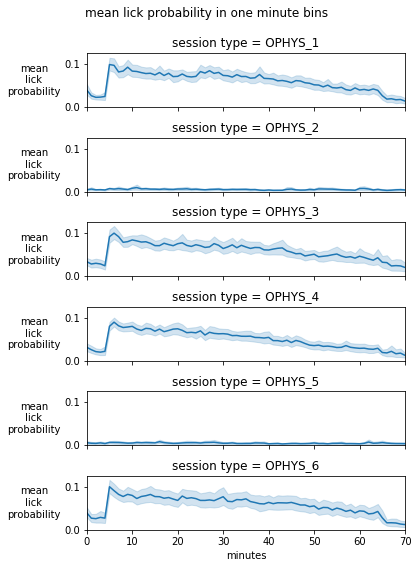

In [25]:
plot_lick_prob_by_minute(preds_by_minute, to_plot='lick');

## plot grooming probabilities in 1 minute bins
These are pretty variable. There don't appear to be strong trends across active/passive, or for particular epochs where grooming is generally high

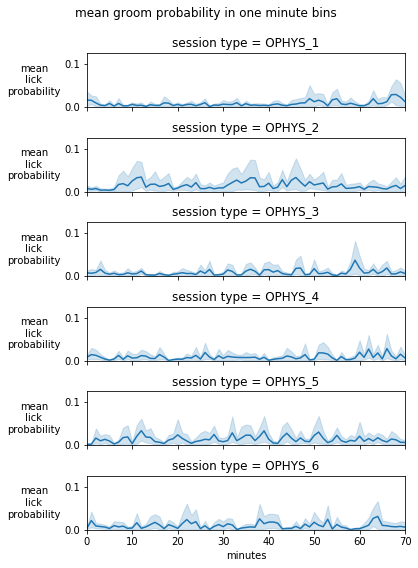

In [27]:
plot_lick_prob_by_minute(preds_by_minute, to_plot='groom');

## a function to plot a single frame

In [15]:
def plot_frame(row, ax):
    osid = 994869518
    v = db.get_well_known_files(row['ophys_session_id']).loc['RawBehaviorTrackingVideo']
    m = vbu.Movie(''.join((v['storage_directory'], v['filename'])))
    ax.imshow(m.get_frame(row['frame_index']))

## a function to plot 10 sample frames from every session type for a given probability range

In [16]:
def plot_examples_by_session(to_plot, low_bound_prob, high_bound_prob = 1):
    n_cols = 10
    fig, ax = plt.subplots(6, n_cols, sharex=True, sharey=True, figsize = (15,8))
    for session_number in range(6):
        sample = preds_df.query('session_type_simple == "OPHYS_{}" and {} > {} and {} < {}'.format((session_number + 1), to_plot, low_bound_prob, to_plot, high_bound_prob)).sample(n_cols, random_state = 1)
        for idx, entry in sample.reset_index().iterrows():
            plot_frame(entry, ax[session_number, idx])
            ax[session_number, idx].set_xticks([])
            ax[session_number, idx].set_yticks([])
            ax[session_number, idx].set_title('probability = {:0.2f}'.format(entry[to_plot]), fontsize = 8)
    #         break

        ax[session_number, 0].set_ylabel('session\ntype\nOPHYS_{}'.format(session_number + 1), va = 'center', rotation = 0, labelpad = 30)

    fig.tight_layout()
    plt.subplots_adjust(hspace=0.2, wspace = 0.01, top=0.9)
    return fig, ax

## look at high probability licks:
These seem to be mostly licks, so the model seems to be doing well, at least when it has high confidence. But note that there aren't any mesoscope sessions in this sample. Maybe the model needs more mesoscope training data

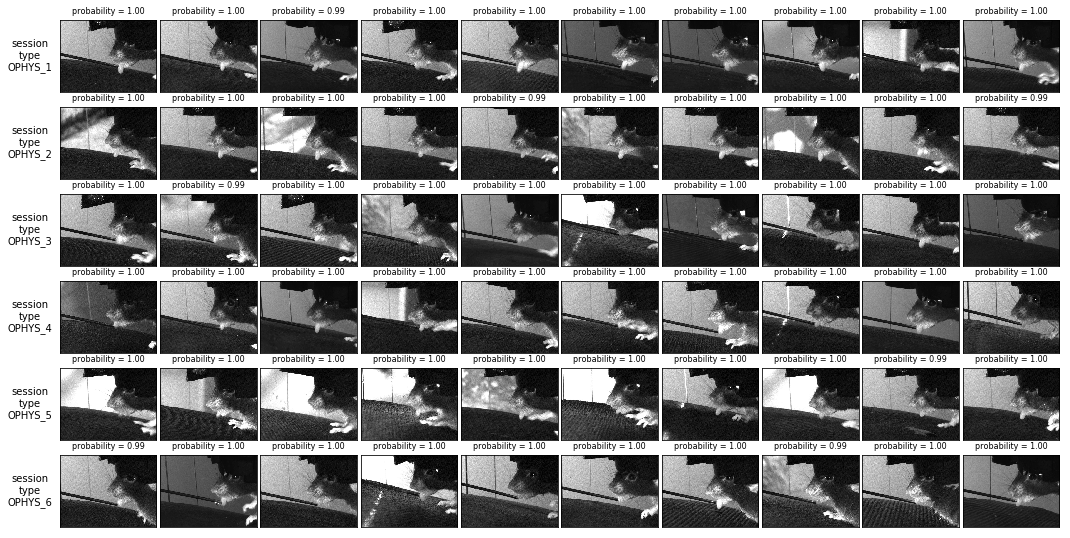

In [17]:
plot_examples_by_session(
    to_plot = 'lick', 
    low_bound_prob = 0.99, 
    high_bound_prob = 1
);

## look at high probability grooming bouts:
These also seem reasonable, but the same caveat about the lack of mesoscope data applies here.


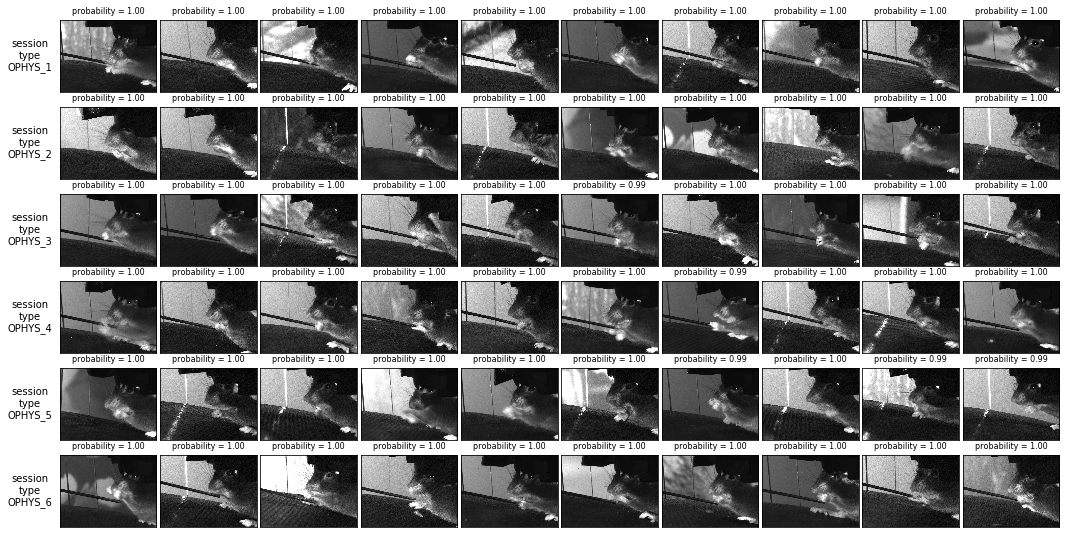

In [18]:
plot_examples_by_session(
    to_plot = 'groom', 
    low_bound_prob = 0.99, 
    high_bound_prob = 1
);

## look at lower probability licks:
Ther seem to be a fair number of mis-labeled frames here:
    * non-licks labeled as licks
    * grooms labeled as licks
    
One caveat, though. I've previously observed that the model has a somewhat uncanny ability to assign elevated licking probabilities to the frames immediately preceding and following actual licks. It's likely that there's some other feature of the face beyond just the presence of the tongue (maybe the whisker pad?) that the model is using to assign the licking probability.  

So while it looks like there are a lot of frames in that last image that are labeled 'lick' with high probability that obviously aren't licks, it may be that the animal just licked, or was just about to lick.

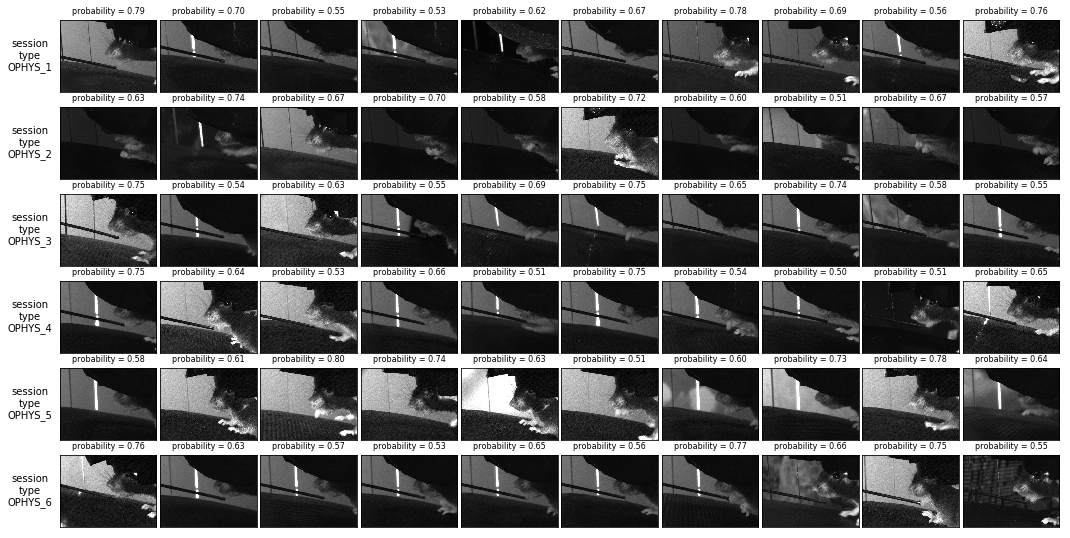

In [20]:
plot_examples_by_session(
    to_plot = 'lick', 
    low_bound_prob = 0.5, 
    high_bound_prob = 0.8
);

In [ ]:
## look at lower probability grooms:
There also seem to be quite a few false positives here. 

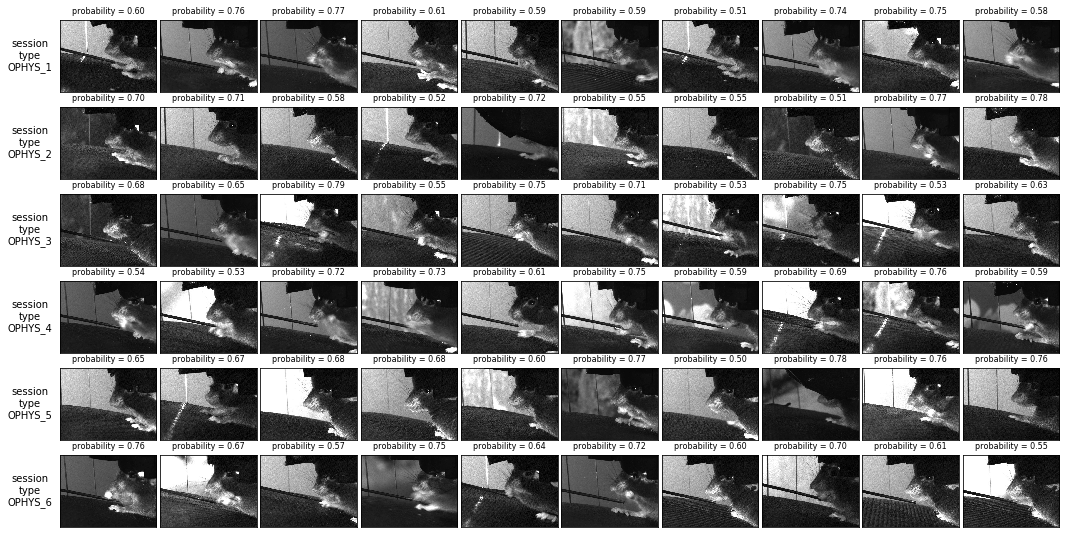

In [19]:
plot_examples_by_session(
    to_plot = 'groom', 
    low_bound_prob = 0.5, 
    high_bound_prob = 0.8
);

# Conclusion
* We have a model that does a pretty good job at identifying licks, even in passive sessions, but we might be able to improve it a bit more if we put in the effort to annotate more frames
* Using this model, we can demonstrate that licks in passive sessions are rare - the animals don't appear to be 'trying to do the task'.